# 🖼️ 04 - Evaluation et Analyse des resultats

L'idée ici est d'analyse les resultats du Calcul. Pour ce faire, nous allons regarder plus en détails **les courbes de Perte, et celle de la Précision** pour  :  
**L'entrainement (training)**, et **la Validation (validation)**.

![Courbes](Evaluate_and_Analyze/data_CNN_h5_V1.0/Precision_Perte_V1.0.png)

<div style="text-align: justify;">

### **1️⃣ Analyse des résultats** :

Dans un premier temps, définissons ce qu'est une **époque**. Une époque correspond à un **passage complet** de toutes les données d'entraînement à travers le modèle.  
Autrement dit, c'est lorsque le modèle a vu l'ensemble des données et a mis à jour ses paramètres en fonction des erreurs commises.

Analysons maintenant l'évolution de la **perte d'entraînement**. Celle-ci montre une diminution progressive à chaque époque, tandis que la **précision d'entraînement** augmente.  
Cela indique que le modèle s'améliore à mesure qu'il s'adapte aux données, minimisant l'erreur (la perte) et améliorant sa capacité à prédire correctement les résultats.

Un comportement similaire est observé pour la **perte de validation**, qui diminue également, et la **précision de validation**, qui augmente. Cela suggère que le modèle généralise bien, en évitant le **surapprentissage** (overfitting), ce qui signifie qu'il ne se contente pas de mémoriser les données d'entraînement, mais qu'il est également capable de bien prédire sur des données qu'il n'a jamais vues auparavant, comme les données de validation.

Une bonne pratique consiste à stopper l'entraînement si aucune amélioration n'est observée après un certain nombre d'époques. Le mécanisme de **"early stopping"** intervient dans ce cas, en se basant sur la perte de validation (`val_loss`). Si cette perte cesse de diminuer ou si la précision de validation stagne après plusieurs époques (selon le paramètre **patience**), l'entraînement est arrêté pour éviter de poursuivre inutilement.


### **2️⃣ Évaluation du Modèle**

Nous allons maintenant charger le modèle enregistré sous le format `.h5` et l'utiliser pour effectuer une prédiction sur une image de microscope 🖼️ qui n'a pas été utilisée pendant l'entraînement ni la validation. 

Le modèle générera un **masque de segmentation**. Ce masque sera superposé à l'image d'origine pour visualiser les résultats. Les régions où la probabilité que l'objet soit un globule blanc est élevée seront colorées en **vert transparent**, afin de les mettre en évidence.

#### Points à noter :
- Avant de faire la prédiction, il est important de **redimensionner** l'image à la taille d'entrée utilisée lors de l'entraînement du modèle (ici, **128x128** pixels). Cela garantit que les dimensions de l'image sont compatibles avec celles attendues par le modèle.

</div>


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


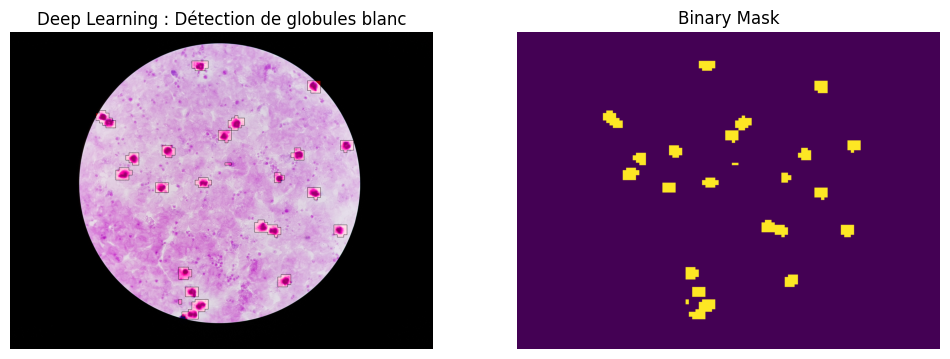

In [3]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Charger le modèle H5
version_model = "V1.0"
data_model = Path(f'./Evaluate_And_Analyze/data_CNN_h5_{version_model}/Globules_blanc_detecteur_{version_model}.h5')
model = load_model(data_model)  # Remplacez par le chemin correct de votre modèle

# Path de l'image de test
image_path = Path("./TF206_15_27SA/tiled/20170816_103009.tiff")

img_size = (128, 128)  # Taille de l'image utilisée pour la prédiction (128x128, car c'est ce que le modèle attend)

def visualize_surface_prediction(image_path, model, size, percentile=97.6):
    """
    Visualise les prédictions du modèle en surlignant les zones détectées (zones blanches),
    et en affichant le masque binaire.
    
    :param image_path: Chemin de l'image d'entrée.
    :param model: Modèle de prédiction.
    :param size: Taille de l'image attendue par le modèle (tuple, ex: (224, 224)).
    :param save_path: Chemin pour sauvegarder l'image résultante.
    :param percentile: Percentile à utiliser pour le seuil de la prédiction (int).
    """
    # Préparer l'image pour le modèle
    img = load_img(image_path, target_size=size)
    img_array = img_to_array(img) / 255.0
    pred = model.predict(np.expand_dims(img_array, axis=0))[0]

    # Ce code crée une image binaire en conservant uniquement les valeurs de pred dont la probabilité 
    # >= à un seuil défini par le percentile spécifié,
    # en les marquant par 1, et les autres par 0.
    threshold = np.percentile(pred, percentile)
    pred_bin = (pred > threshold).astype(np.uint8)

    # Charger l'image originale et redimensionner la prédiction
    original_img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    pred_bin_resized = cv2.resize(pred_bin, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Créer un masque de couleur verte (RGBA) avec opacité 50% pour les zones détectées
    # > Nouvelle matrice overlay aux mêmes dimensions que l'image d'origine initialisée avec des zéros.
    overlay = np.zeros_like(original_img)
    # Cette ligne colore en vert tous les pixels de l'image overlay correspondant aux zones marquées comme détectées (valeurs égales à 1) 
    # dans le masque binaire pred_bin_resized.
    overlay[pred_bin_resized == 1] = [255, 0, 0]  # Vert pur pour les zones détectées
    # Cette ligne fusionne l'image overlay avec l'image d'origine original_img, en superposant overlay avec une transparence de 55%,
    # créant ainsi une image combinée où les zones d'intérêt sont mises en évidence.
    blended_img = cv2.addWeighted(original_img, 1.0, overlay, 0.55, 0)

    # Afficher les résultats : image avec overlay et masque binaire
    plt.figure(figsize=(12, 6))

    contours, _ = cv2.findContours(pred_bin_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(blended_img, contours, -1, (0, 0, 0), 2)  # Dessiner les contours

    # Subplot 1: Image avec overlay
    plt.subplot(1, 2, 1)
    plt.imshow(blended_img)
    plt.title(f"Deep Learning : Détection de globules blanc")
    plt.axis('off')

    # Subplot 2: Masque binaire
    plt.subplot(1, 2, 2)
    plt.imshow(pred_bin_resized)
    plt.title("Binary Mask")
    plt.axis('off')
    # Sauvegarder l'image résultante
    plt.savefig(f"WBC_PREDICTED_{version_model}.png")
    # Afficher les images
    plt.show()

visualize_surface_prediction(image_path, model, img_size)